In [1]:
# Importing the matplotlb.pyplot
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import re
import math
import numpy as np

RELEASE = 0
ENTRY = 0
EXIT = 1

thread_re = re.compile('[\w-]+-[0-9]+')
core_re = re.compile('\[[0-9]{3}\]')
timestamp_re = re.compile('[0-9]+\.[0-9]{6}')
func_re = re.compile(': [\w]+_(release|entry|exit):')

In [2]:
# Data stored as
# {
#   "func_name" : [
#     {"thread": #, "timings": [#, #]},
#     ...
#   ],
#   ...
# }

data = {}
threads = []
start = math.inf
end = -math.inf

#NOTE: EDITABBLE (filename)
with open("report_concurrent_children.txt") as fin:
    for line in fin:
        func_name = func_re.search(line).group()[2:-1]
        thread = thread_re.search(line).group()
        time = float(timestamp_re.search(line).group())
        cpu_core = int(core_re.search(line).group()[1:-1])
        event_type = func_name.split('_')[-1]
        func_name = "_".join(func_name.split('_')[:-1])

        if time < start:
            start = time
        if time > end:
            end = time

        if not func_name in data.keys():
            data[func_name] = []
        
        if not thread in threads:
            threads.append(thread)
            
        # TODO: Change this to release when those are implemented and change the tuple from a duo to a trio
        if event_type == "entry":
            data[func_name].append({"thread": thread, "timings": [time, -1]})
        elif event_type == "exit":
            assert(data[func_name][-1]["timings"][ENTRY] > 0)   # Exit is first event seen for this function
            assert(data[func_name][-1]["timings"][EXIT] == -1)  # Exit without an entrance
            assert(data[func_name][-1]["thread"] == thread)     # Exited on thread different from one entered into   
            

            data[func_name][-1]["timings"][EXIT] = time     


In [3]:
# NOTE: EDITABBLE
timelimit_ms = 3000

# NOTE: EDITABBLE
# Put text substitutions here for prettier graph
# function_remapping = {"mt_exec_shared_node_publishing_timer": "Timer",
#                       "mt_exec_shared_node_high_prio_callback": "High",
#                       "mt_exec_shared_node_med_prio_callback": "Mid",
#                       "mt_exec_shared_node_low_prio_callback": "Low"}
# function_remapping = {"mt_exec_personal_nodes_publishing_timer": "Timer",
#                       "mt_exec_personal_nodes_subscriber_callback1": "High",
#                       "mt_exec_personal_nodes_subscriber_callback2": "Mid",
#                       "mt_exec_personal_nodes_subscriber_callback3": "Low"}
function_remapping = {"mt_exec_casini_copy_timer1_callback": "Timer1",
                      "mt_exec_casini_copy_timer2_callback": "Timer2",
                      "mt_exec_casini_copy_hi_subscriber_callback": "H",
                      "mt_exec_casini_copy_me_subscriber_callback": "M",
                      "mt_exec_casini_copy_lo_subscriber_callback": "L",
                      "mt_exec_casini_copy_hi_service_callback": "SH",
                      "mt_exec_casini_copy_me_service_callback": "SM",
                      "mt_exec_casini_copy_lo_service_callback": "SL"}


# TODO: Rewrite a lot of this when release implemented
# Converts data to express time in ms, relative to start of benchmark. Crop of
# tasks that occur after timelimit
interm = dict.fromkeys(function_remapping.values())
for f, l in data.items():
    if f in function_remapping.keys():
        f = function_remapping[f]

    interm[f] = [{"thread" : v["thread"],
                "timings": (1000*(v["timings"][ENTRY]-start),
                            1000*(v["timings"][EXIT]-start) if v["timings"][EXIT] > 0 else timelimit_ms)
                } for v in l if 1000*(v["timings"][ENTRY]-start) < timelimit_ms]

data = interm
del interm


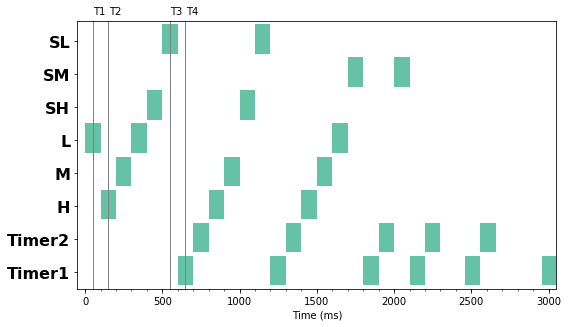

In [4]:
# Map each thread to unique color
color_mappings = dict(zip(threads, plt.get_cmap("Set2")(np.linspace(0,1,len(threads)))))

# Declaring a figure "gnt"
fig, gnt = plt.subplots()
 
# Setting Y-axis limits
num_funs = len(data.keys())
gnt.set_ylim(0, 1+10*num_funs)
 
# Setting X-axis limits
gnt.set_xlim(-50, timelimit_ms+50)
gnt.xaxis.set_major_locator(MultipleLocator(500))
gnt.xaxis.set_minor_locator(MultipleLocator(100))
 
# NOTE: EDITABLE
# Setting labels for x-axis and y-axis
#gnt.set_title('Scheduability Test')
gnt.set_xlabel('Time (ms)')

# NOTE: EDITABLE
# Set reference lines in chart
# for i, xc in enumerate([50, 150, 550, 650]):
#     plt.axvline(x=xc, color="gray", linestyle='-', linewidth=1)
#     plt.text(xc+3, 10*num_funs+3, "T%d"%(i+1))
# plt.axvline(x=0, color=list(color_mappings.values())[0], linestyle='--', linewidth=1)
# plt.axvline(x=220, color=list(color_mappings.values())[1], linestyle='--', linewidth=1)
# plt.axvline(x=600, color=list(color_mappings.values())[0], linestyle='--', linewidth=1)
# plt.axvline(x=800, color=list(color_mappings.values())[0], linestyle='--', linewidth=1)

 
# Setting ticks on y-axis
gnt.set_yticks(list(range(5,num_funs*10+5, 10)))
# Labelling tickes of y-axis
gnt.set_yticklabels(data.keys(), fontdict={'family': 'sans', 'weight': 'bold', 'size': 16})
 
i = 0
for f, l in data.items():
    colors = [color_mappings[v["thread"]] for v in l]
    timings = [(v["timings"][ENTRY], v["timings"][EXIT]-v["timings"][ENTRY]) for v in l]

    gnt.broken_barh(timings, (1+i, 9), facecolors=colors)
    i+=10
 
fig.set_size_inches(8, 4.5)
plt.tight_layout()

# NOTE: EDITABLE
plt.savefig("mt_exec_ready_set.png")